### Installing important libraries


In [109]:
!pip install vaderSentiment
!pip install pandas-datareader

In [110]:
# Import required libraries
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from datetime import datetime
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import yfinance as yf
import pandas_datareader.data as web
import datetime
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Flatten, LSTM
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
import random
import seaborn as sns
import mplfinance as mpf

### Uploading excel data file for analysis

In [57]:
news = pd.read_excel('Ydata.xlsx')

In [58]:
news.head()

,publish,title,description,channel_name,transcript
0,2024-06-27 21:08:43,Micron is still &#39;trending in the right dir...,Micron Technology (MU) reported fourth quarter...,Yahoo Finance,let's take a look at Micron because Shares are...
1,2024-06-26 16:15:02,Why Nvidia’s rise is similar to the dot-com bu...,"With Nvidia up over 154% year to date, Stifel ...",Yahoo Finance,Barry going back to what you were just saying ...
2,2024-06-25 23:24:23,"It&#39;s Nvidia&#39;s market, and we&#39;re al...",Shares of Nvidia (NVDA) are rebounding in Tues...,Yahoo Finance,let me ask you this Steve so uh Peter bvar tod...
3,2024-06-24 23:21:08,"Treasury Secretary Janet Yellen talks housing,...",The Biden administration announced a series of...,Yahoo Finance,secretary Yellen thank you so much for sitting...
4,2024-06-20 22:08:13,Stock market today: Stocks turn lower as Nvidi...,stocks #inflation #YahooFinance #recession #bi...,Yahoo Finance,Hello and welcome to Market Domination. I'm Ju...


In [59]:
news.shape

(13315, 5)

### Downloading NLTK for processing of text

In [60]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bhart\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\bhart\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\bhart\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### Data Pre-processing

In [61]:
# Converting the 'publish' column to datetime objects
news['date'] = pd.to_datetime(news['publish'])

In [62]:
# Extracting the date component and assigning it back to the 'publish' column
news['date'] = news['date'].dt.date

In [63]:
# drop duplicates
news_final = news.drop_duplicates([ 'date', 'title', 'description', 'channel_name', 'transcript'], keep ='last')

In [65]:
# remove the news where transcript is not available
news_final = news_final[~news_final.transcript.isnull()]

In [66]:
news_final.shape

(13004, 6)

In [67]:
# create a new dataframe for data preprocessing
df = news_final.copy()

# Initializing NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Cleaning of the text
def clean_text(text):
    #print(text)
    # Lowercase the text
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])
    # Lemmatize words
    text = ' '.join([lemmatizer.lemmatize(word) for word in text.split()])
    # Remove extra whitespaces
    text = text.strip()
    return text

# Appling text cleaning
df['cleaned_text'] = df['transcript'].apply(clean_text)

# Comprehensive list including stock market-related keywords
stock_market_keywords = [
    'stock', 'stocks', 'market', 'shares', 'equity', 'equities', 'ipo', 'ipos', 'initial public offering',
    's&p', 'dow', 'nasdaq', 'index', 'indexes', 'indices', 'futures', 'options', 'trading', 'traded', 'bull',
    'bear', 'bullish', 'bearish', 'buy', 'sell', 'buyback', 'dividend', 'dividends', 'earnings', 'quarterly',
    'profits', 'losses', 'revenue', 'guidance', 'forecast', 'analyst', 'analysts', 'securities', 'investment',
    'invest', 'investor', 'investors', 'hedge fund', 'hedge funds', 'mutual fund', 'mutual funds', 'etf', 'etfs',
    'bond', 'bonds', 'commodity', 'commodities', 'derivative', 'derivatives', 'currency', 'currencies', 'forex',
    'foreign exchange', 'interest rate', 'interest rates', 'yield', 'yield curve', 'inflation', 'inflationary',
    'deflation', 'recession', 'economic slowdown', 'gdp', 'gross domestic product', 'federal reserve', 'fed',
    'central bank', 'monetary policy', 'quantitative easing', 'qe', 'tapering', 'stimulus', 'tariff', 'tariffs',
    'trade war', 'trade deficit', 'trade surplus', 'unemployment rate', 'jobless claims', 'payroll', 'payrolls',
    'earnings report', 'financial report', 'balance sheet', 'cash flow', 'income statement', 'debt', 'credit',
    'rating', 'credit rating', 'default', 'bankruptcy', 'merger', 'acquisition', 'm&a', 'ipo', 'public offering',
    'private equity', 'venture capital', 'valuation', 'capital gains', 'capital loss', 'tax', 'taxes', 'tax rate',
    'corporate tax', 'corporate earnings', 'short selling', 'short seller', 'market cap', 'capitalization',
    'diversification', 'portfolio', 'hedging', 'insider trading', 'price-to-earnings', 'p/e ratio', 'earnings per share',
    'eps', 'price target', 'upgrade', 'downgrade', 'buy rating', 'sell rating', 'hold rating', 'overweight',
    'underweight', 'neutral', 'volatility', 'vix', 'volume', 'liquidity', 'capital markets', 'brokerage', 'broker',
    'analyst call', 'closing price', 'open price', 'high', 'low', '52-week high', '52-week low', 'sector',
    'industry', 'blue chip', 'penny stock', 'small cap', 'mid cap', 'large cap', 'growth stock', 'value stock',
    'emerging market', 'developed market', 'diversified', 'rebalancing', 'tranche', 'buying pressure', 'selling pressure',
    'earnings call', 'conference call', 'shareholder', 'stakeholder', 'equity market', 'financial markets',
    'exchange', 'securities exchange', 'commodities market', 'derivatives market', 'bond market', 'forex market',
    'cryptocurrency', 'crypto', 'bitcoin', 'ethereum', 'blockchain', 'token', 'mining', 'regulation', 'regulated',
    'sec', 'securities and exchange commission', 'insider', 'regulatory filing', '10-k', '10-q', 'proxy statement',
    'filing', 'disclosure', 'prospectus', 'underwriting', 'listing', 'delisting', 'stock split', 'reverse split',
    'share buyback', 'repurchase', 'all-time high', 'all-time low', 'record high', 'record low'
]

# Classify news using function
def classify_news(text):
    for keyword in stock_market_keywords:
        if keyword in text.lower():
            return 'Stock Market'
    return 'Other'

# Apply the classification
df['category'] = df['cleaned_text'].apply(classify_news)

# Initializing VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get sentiment score
def get_sentiment_score(text):
    score = analyzer.polarity_scores(text)
    print(text.split()[:5])
    print(score)
    return score['compound']  # The compound score is a normalized, weighted composite score

# Appling sentiment analysis only to Stock Market news
df['sentiment_score'] = df.apply(lambda x: get_sentiment_score(x['cleaned_text']) if x['category'] == 'Stock Market' else 0, axis=1)

# Converting the date column to datetime type
df['date'] = pd.to_datetime(df['date'])

['let', 'take', 'look', 'micron', 'share']
{'neg': 0.048, 'neu': 0.685, 'pos': 0.266, 'compound': 0.9996}
['barry', 'going', 'back', 'saying', 'minute']
{'neg': 0.013, 'neu': 0.827, 'pos': 0.16, 'compound': 0.9926}
['let', 'ask', 'steve', 'uh', 'peter']
{'neg': 0.093, 'neu': 0.772, 'pos': 0.136, 'compound': 0.9854}
['secretary', 'yellen', 'thank', 'much', 'sitting']
{'neg': 0.089, 'neu': 0.701, 'pos': 0.21, 'compound': 0.9994}
['hello', 'welcome', 'market', 'domination', 'im']
{'neg': 0.032, 'neu': 0.75, 'pos': 0.218, 'compound': 1.0}
['music', 'weve', 'read', 'headline', 'genz']
{'neg': 0.014, 'neu': 0.762, 'pos': 0.225, 'compound': 0.9983}
['one', 'area', 'market', 'really', 'shining']
{'neg': 0.066, 'neu': 0.77, 'pos': 0.164, 'compound': 0.9907}
['certainly', 'rough', 'start', 'year', 'stock']
{'neg': 0.077, 'neu': 0.692, 'pos': 0.231, 'compound': 0.9991}
['im', 'confident', 'tesla', 'world', 'india']
{'neg': 0.015, 'neu': 0.706, 'pos': 0.279, 'compound': 0.9623}
['thank', 'welcome'

In [68]:
# Grouping by date and summing up the sentiment scores for Stock Market news
daily_sentiment = df[df['category'] == 'Stock Market'].groupby('date')['sentiment_score'].sum().reset_index()

# Display the result
print(daily_sentiment)

          date  sentiment_score
0   2022-06-01          -0.0043
1   2022-06-02           1.9983
2   2022-06-03           0.9999
3   2022-06-04           0.9996
4   2022-06-05           1.9993
..         ...              ...
750 2024-06-27          39.9479
751 2024-06-28          41.2780
752 2024-06-29          18.6465
753 2024-06-30          39.5609
754 2024-07-01           1.9713

[755 rows x 2 columns]


In [70]:
news_final.head()

,publish,title,description,channel_name,transcript,date
0,2024-06-27 21:08:43,Micron is still &#39;trending in the right dir...,Micron Technology (MU) reported fourth quarter...,Yahoo Finance,let's take a look at Micron because Shares are...,2024-06-27
1,2024-06-26 16:15:02,Why Nvidia’s rise is similar to the dot-com bu...,"With Nvidia up over 154% year to date, Stifel ...",Yahoo Finance,Barry going back to what you were just saying ...,2024-06-26
2,2024-06-25 23:24:23,"It&#39;s Nvidia&#39;s market, and we&#39;re al...",Shares of Nvidia (NVDA) are rebounding in Tues...,Yahoo Finance,let me ask you this Steve so uh Peter bvar tod...,2024-06-25
3,2024-06-24 23:21:08,"Treasury Secretary Janet Yellen talks housing,...",The Biden administration announced a series of...,Yahoo Finance,secretary Yellen thank you so much for sitting...,2024-06-24
4,2024-06-20 22:08:13,Stock market today: Stocks turn lower as Nvidi...,stocks #inflation #YahooFinance #recession #bi...,Yahoo Finance,Hello and welcome to Market Domination. I'm Ju...,2024-06-20


In [71]:
daily_sentiment['date'].min()

Timestamp('2022-06-01 00:00:00')

In [72]:
daily_sentiment['date'].max()

Timestamp('2024-07-01 00:00:00')

[*********************100%%**********************]  1 of 1 completed
C:\Users\bhart\AppData\Local\Temp\ipykernel_30772\3299702379.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ftse250['rolling_return'] = ftse250['daily_return'].rolling(window=15).sum()
C:\Users\bhart\AppData\Local\Temp\ipykernel_30772\3299702379.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ftse250['rolling_volatility'] = ftse250['volatility'].rolling(window=15).sum()
C:\Users\bhart\AppData\Local\Temp\ipykernel_30772\329970237

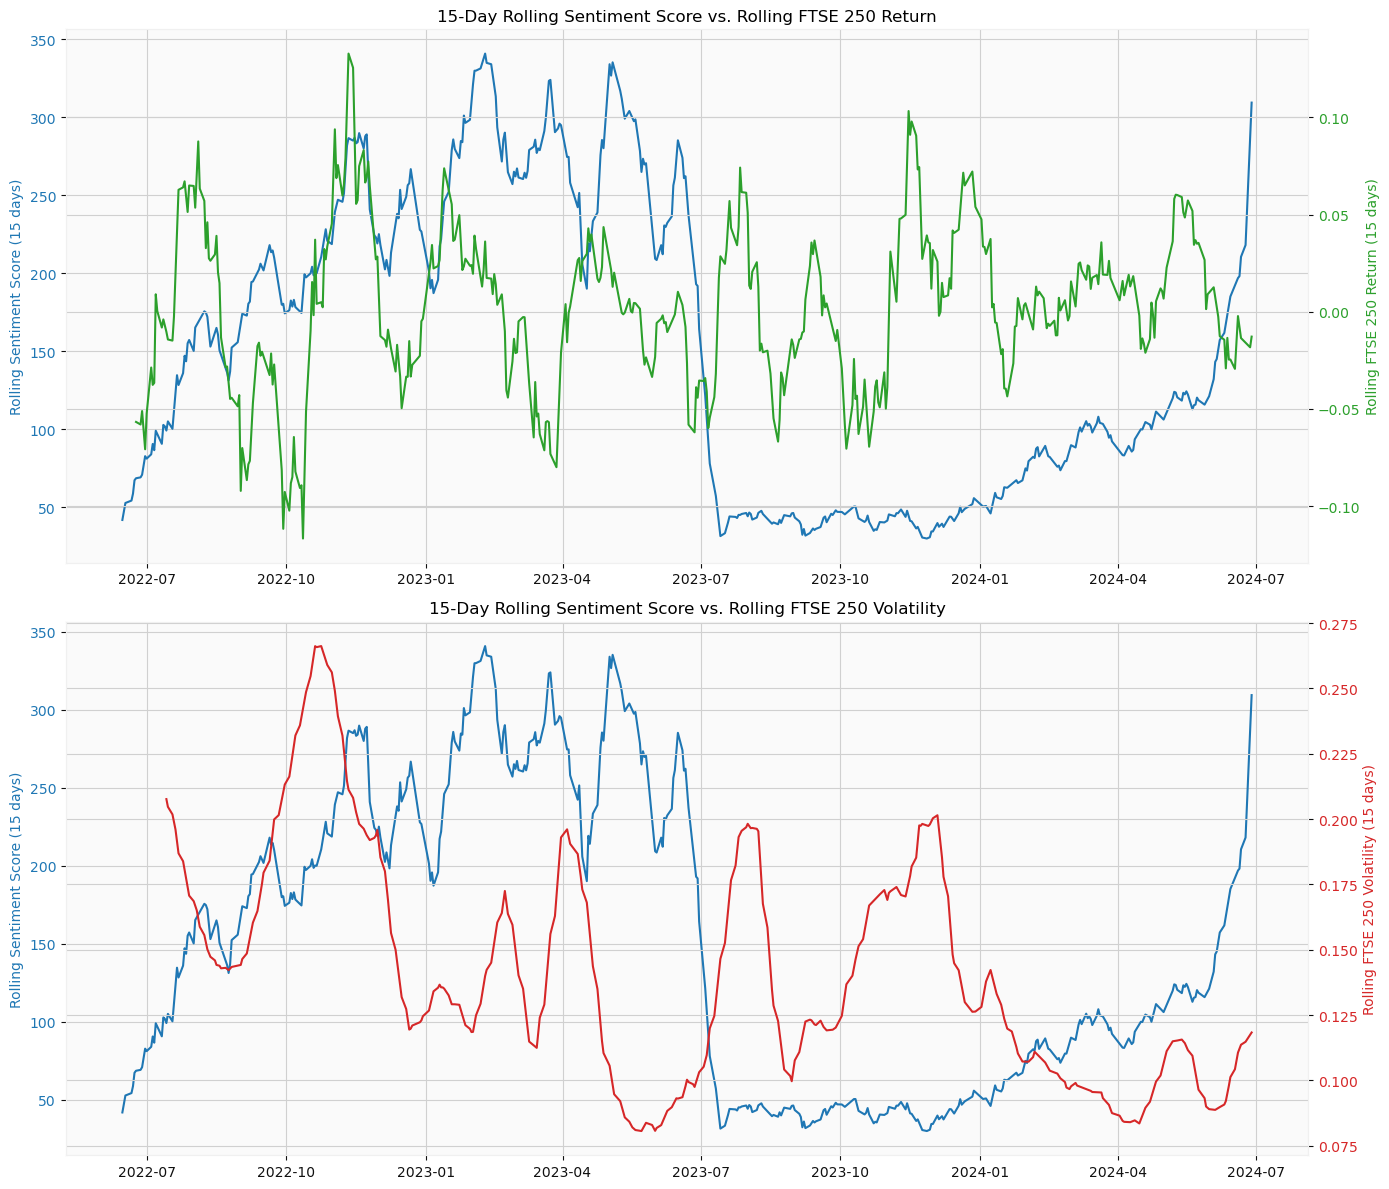

In [74]:
# Getting FTSE 250 data
ftse250 = yf.download('^FTMC', start=daily_sentiment['date'].min(), end=daily_sentiment['date'].max())

# Calculating daily returns and volatility
ftse250['daily_return'] = ftse250['Adj Close'].pct_change()
ftse250['volatility'] = ftse250['daily_return'].rolling(window=15).std()

# Dropping the first row with NaN in daily_return
ftse250 = ftse250.dropna(subset=['daily_return'])

# Calculating rolling sums over 15 days
daily_sentiment['rolling_sentiment'] = daily_sentiment['sentiment_score'].rolling(window=15).sum()
ftse250['rolling_return'] = ftse250['daily_return'].rolling(window=15).sum()
ftse250['rolling_volatility'] = ftse250['volatility'].rolling(window=15).sum()

# Merging sentiment data with FTSE 250 returns and volatility
ftse250['date'] = ftse250.index  # Add date column to FTSE 250 data
ftse250 = ftse250[['date', 'rolling_return', 'rolling_volatility']]  # Keep relevant columns

# Merge on date
merged_data = pd.merge(daily_sentiment, ftse250, how='inner', on='date')

# Plotting comparison plots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Plot rolling sentiment score vs rolling return
ax1.plot(merged_data['date'], merged_data['rolling_sentiment'], color='tab:blue', label='Rolling Sentiment Score')
ax1.set_ylabel('Rolling Sentiment Score (15 days)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax1_twin = ax1.twinx()
ax1_twin.plot(merged_data['date'], merged_data['rolling_return'], color='tab:green', label='Rolling FTSE 250 Return')
ax1_twin.set_ylabel('Rolling FTSE 250 Return (15 days)', color='tab:green')
ax1_twin.tick_params(axis='y', labelcolor='tab:green')

ax1.set_title('15-Day Rolling Sentiment Score vs. Rolling FTSE 250 Return')

# Plot rolling sentiment score vs rolling volatility
ax2.plot(merged_data['date'], merged_data['rolling_sentiment'], color='tab:blue', label='Rolling Sentiment Score')
ax2.set_ylabel('Rolling Sentiment Score (15 days)', color='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:blue')

ax2_twin = ax2.twinx()
ax2_twin.plot(merged_data['date'], merged_data['rolling_volatility'], color='tab:red', label='Rolling FTSE 250 Volatility')
ax2_twin.set_ylabel('Rolling FTSE 250 Volatility (15 days)', color='tab:red')
ax2_twin.tick_params(axis='y', labelcolor='tab:red')

ax2.set_title('15-Day Rolling Sentiment Score vs. Rolling FTSE 250 Volatility')

fig.tight_layout()
plt.show()

[*********************100%%**********************]  1 of 1 completed
C:\Users\bhart\AppData\Local\Temp\ipykernel_30772\1996962775.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ftse250['date'] = ftse250.index  # Add date column to FTSE 250 data


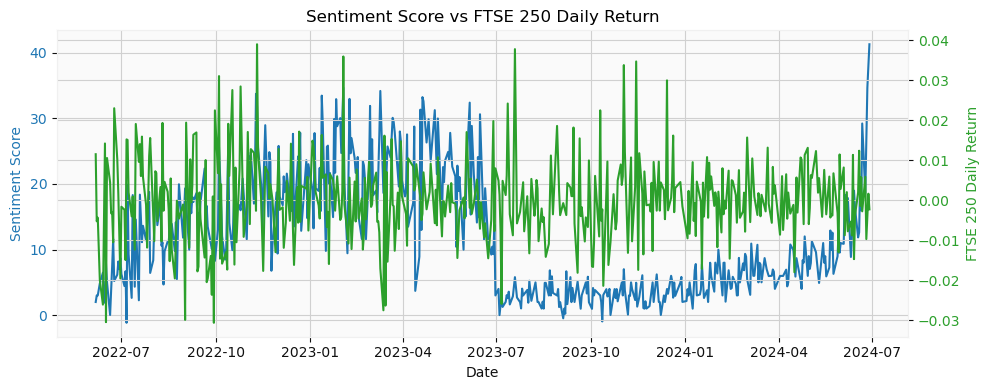

In [121]:
# Getting FTSE 250 data
ftse250 = yf.download('^FTMC', start=daily_sentiment['date'].min(), end=daily_sentiment['date'].max())

# Calculating daily returns
ftse250['daily_return'] = ftse250['Adj Close'].pct_change()


# Dropping the first row with NaN in daily_return
ftse250 = ftse250.dropna(subset=['daily_return'])

# Merging sentiment data with FTSE 250 returns and volatility
ftse250['date'] = ftse250.index  # Add date column to FTSE 250 data
ftse250 = ftse250[['date', 'Adj Close', 'daily_return']]  # Keep relevant columns
# ftse250['date'] = pd.to_datetime(ftse250['date']).dt.date
# Merge on date
merged_data = pd.merge(daily_sentiment, ftse250, how='inner', on='date')


# Create a figure and a single subplot
fig, ax1 = plt.subplots(figsize=(10, 4))

# Plot the sentiment score and FTSE 250 daily return
ax1.set_xlabel('Date')
ax1.set_ylabel('Sentiment Score', color='tab:blue')
ax1.plot(merged_data['date'], merged_data['sentiment_score'], color='tab:blue', label='Sentiment Score')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax3 = ax1.twinx()
ax3.set_ylabel('FTSE 250 Daily Return', color='tab:green')
ax3.plot(merged_data['date'], merged_data['daily_return'], color='tab:green', label='FTSE 250 Daily Return')
ax3.tick_params(axis='y', labelcolor='tab:green')

ax1.set_title('Sentiment Score vs FTSE 250 Daily Return')


fig.tight_layout()  # Prevents overlap of labels
plt.show()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


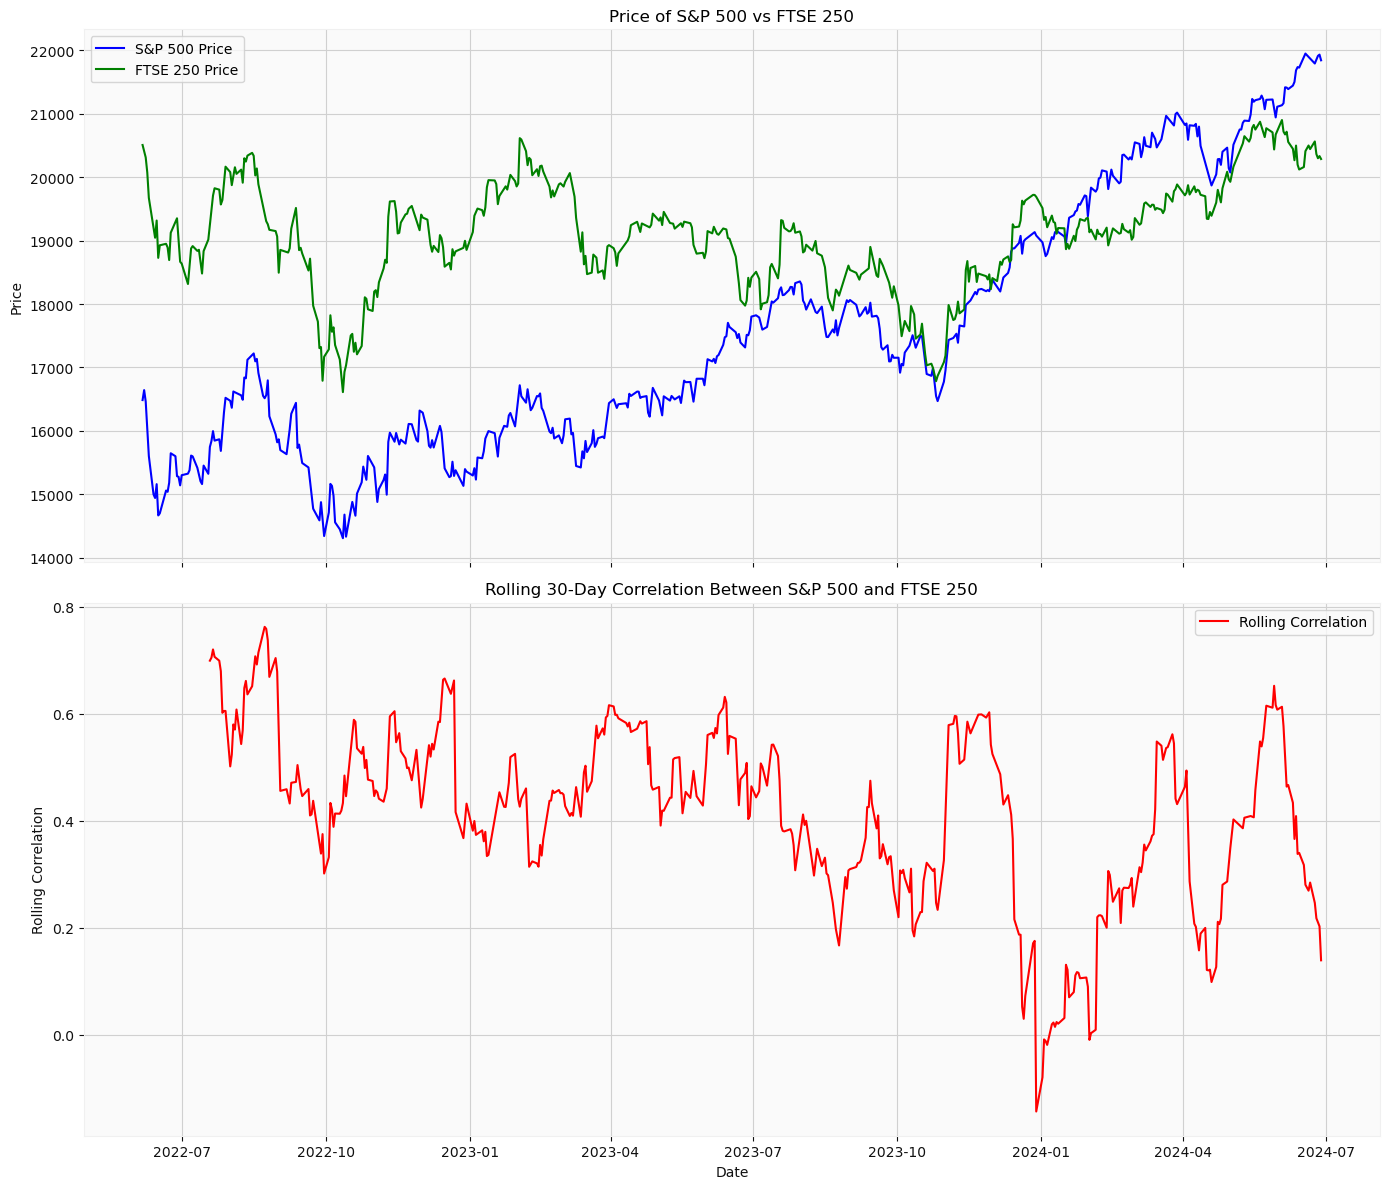

In [76]:
# Define the date range
start_date = '2022-06-01'
end_date = '2024-07-01'

# Download FTSE 250 and S&P 500 data
ftse250 = yf.download('^FTMC', start=start_date, end=end_date)
sp500 = yf.download('^GSPC', start=start_date, end=end_date)

# Calculate daily returns
ftse250['daily_return'] = ftse250['Adj Close'].pct_change()
sp500['daily_return'] = sp500['Adj Close'].pct_change()

# Drop the first row with NaN in daily_return
ftse250 = ftse250.dropna(subset=['daily_return'])
sp500 = sp500.dropna(subset=['daily_return'])

# Align indices
data = pd.merge(sp500[['Adj Close', 'daily_return']], ftse250[['Adj Close', 'daily_return']], 
                 left_index=True, right_index=True, suffixes=('_sp500', '_ftse250'))

# Calculate rolling correlation
window = 30  # Rolling window size, e.g., 30 days
data['rolling_correlation'] = data['daily_return_sp500'].rolling(window=window).corr(data['daily_return_ftse250'])

# Plotting the prices and rolling correlation
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

# Plot prices
ax1.plot(data.index, data['Adj Close_sp500']*4, color='blue', label='S&P 500 Price')
ax1.plot(data.index, data['Adj Close_ftse250'], color='green', label='FTSE 250 Price')
ax1.set_ylabel('Price')
ax1.set_title('Price of S&P 500 vs FTSE 250')
ax1.legend()
ax1.grid(True)

# Plot rolling correlation
ax2.plot(data.index, data['rolling_correlation'], color='red', label='Rolling Correlation')
ax2.set_xlabel('Date')
ax2.set_ylabel('Rolling Correlation')
ax2.set_title(f'Rolling {window}-Day Correlation Between S&P 500 and FTSE 250')
ax2.legend()
ax2.grid(True)

# Show plot
plt.tight_layout()
plt.show()

In [77]:


# Define the date range
start_date = '2022-06-01'
end_date = '2024-07-01'

# Download FTSE 250 and S&P 500 data
ftse250 = yf.download('^FTMC', start=start_date, end=end_date)
sp500 = yf.download('^GSPC', start=start_date, end=end_date)

# Calculate daily returns
ftse250['daily_return'] = ftse250['Adj Close'].pct_change()
sp500['daily_return'] = sp500['Adj Close'].pct_change()

# Drop the first row with NaN in daily_return
ftse250 = ftse250.dropna(subset=['daily_return'])
sp500 = sp500.dropna(subset=['daily_return'])

# Align indices
data = pd.merge(sp500[['daily_return']], ftse250[['daily_return']], 
                 left_index=True, right_index=True, suffixes=('_sp500', '_ftse250'))

# Calculate correlation
correlation = data['daily_return_sp500'].corr(data['daily_return_ftse250'])

# Convert correlation to percentage
correlation_percentage = correlation * 100

# Print the result
print(f'Correlation between S&P 500 and FTSE 250 daily returns: {correlation_percentage:.2f}%')


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

Correlation between S&P 500 and FTSE 250 daily returns: 47.08%


In [78]:
# Defining the date range for the data analysis
start_date = "2022-06-01"
end_date = "2024-07-01"

# Fetching historical data for FTSE 250
ftse_250_data = yf.download("^FTMC", start=start_date, end=end_date).reset_index()
ftse_250_data['Date'] = ftse_250_data['Date'].dt.date

[*********************100%%**********************]  1 of 1 completed


In [79]:
ftse_250_data.rename(columns={'Date': 'date'}, inplace=True)
ftse_250_data.tail()

,date,Open,High,Low,Close,Adj Close,Volume
518,2024-06-24,20442.400391,20580.199219,20356.000000,20562.599609,20562.599609,240816200
519,2024-06-25,20562.599609,20562.599609,20350.699219,20363.400391,20363.400391,269045600
520,2024-06-26,20363.400391,20451.199219,20268.300781,20298.099609,20298.099609,302862500
521,2024-06-27,20298.099609,20368.099609,20288.199219,20331.800781,20331.800781,272568700
522,2024-06-28,20331.800781,20386.699219,20250.800781,20286.000000,20286.000000,242205400


In [80]:
# Converting the 'Date' column in interest_rate_data to datetime64[ns]
daily_sentiment['date'] = pd.to_datetime(daily_sentiment['date'])
ftse_250_data['date'] = pd.to_datetime(ftse_250_data['date'])

In [81]:
merge_data = pd.merge(ftse_250_data, daily_sentiment , on='date', how='left')
merge_data['sentiment_score'] = merge_data['sentiment_score'].shift(1)

In [82]:
data = merge_data.copy()

In [83]:
# Filling missing values column-wise using forward fill
data = data.ffill()

In [84]:
data = data.dropna()

In [85]:
# Seting 'Date' back to index if desired
data.set_index('date', inplace=True)

In [86]:
data.head(10)

,Open,High,Low,Close,Adj Close,Volume,sentiment_score,rolling_sentiment
date,,,,,,,,
2022-06-15,19045.000000,19368.300781,19044.500000,19316.000000,19316.000000,430608000,1.9274,41.8714
2022-06-16,19316.000000,19316.400391,18727.500000,18727.500000,18727.500000,562929800,1.8959,49.7287
2022-06-17,18727.500000,19084.500000,18704.199219,18925.900391,18925.900391,775453500,7.8530,52.7378
2022-06-20,18925.900391,19019.800781,18909.300781,19010.800781,19010.800781,263576900,5.0074,53.4564
2022-06-21,19010.800781,19144.599609,18948.500000,18949.099609,18949.099609,266090000,0.0229,54.2810
2022-06-22,18949.099609,18955.599609,18629.699219,18891.199219,18891.199219,387675100,2.8238,58.7184
2022-06-23,18891.199219,18891.300781,18653.500000,18693.000000,18693.000000,262632000,7.4367,67.2990
2022-06-24,18693.000000,19127.300781,18693.000000,19123.699219,19123.699219,276150100,11.5766,68.5876
2022-06-27,19123.699219,19397.400391,19120.000000,19319.000000,19319.000000,280520400,5.2029,69.1636


In [87]:
data.describe()

,Open,High,Low,Close,Adj Close,Volume,sentiment_score,rolling_sentiment
count,515.000000,515.000000,515.000000,515.000000,515.000000,5.150000e+02,515.00000,515.000000
mean,19061.597319,19173.134011,18951.771253,19064.018291,19064.018291,3.039436e+08,12.16125,150.891454
std,849.375476,833.643036,864.595585,851.101513,851.101513,9.751262e+07,9.01011,94.207224
min,16611.199219,16889.500000,16520.500000,16611.199219,16611.199219,6.788580e+07,-1.16940,29.971300
25%,18569.700195,18675.900391,18476.699219,18569.700195,18569.700195,2.464980e+08,4.23615,54.558250
50%,19129.699219,19224.699219,19062.199219,19131.199219,19131.199219,2.867588e+08,9.76210,128.341300
75%,19607.750000,19715.399414,19517.750000,19614.849609,19614.849609,3.399484e+08,18.94315,231.843550
max,20900.500000,20939.599609,20749.900391,20900.500000,20900.500000,9.730681e+08,39.94790,340.667200


Summary Statistics:
               Open          High           Low         Close     Adj Close  \
count    515.000000    515.000000    515.000000    515.000000    515.000000   
mean   19061.597319  19173.134011  18951.771253  19064.018291  19064.018291   
std      849.375476    833.643036    864.595585    851.101513    851.101513   
min    16611.199219  16889.500000  16520.500000  16611.199219  16611.199219   
25%    18569.700195  18675.900391  18476.699219  18569.700195  18569.700195   
50%    19129.699219  19224.699219  19062.199219  19131.199219  19131.199219   
75%    19607.750000  19715.399414  19517.750000  19614.849609  19614.849609   
max    20900.500000  20939.599609  20749.900391  20900.500000  20900.500000   

             Volume  sentiment_score  rolling_sentiment  
count  5.150000e+02        515.00000         515.000000  
mean   3.039436e+08         12.16125         150.891454  
std    9.751262e+07          9.01011          94.207224  
min    6.788580e+07         -1.16940

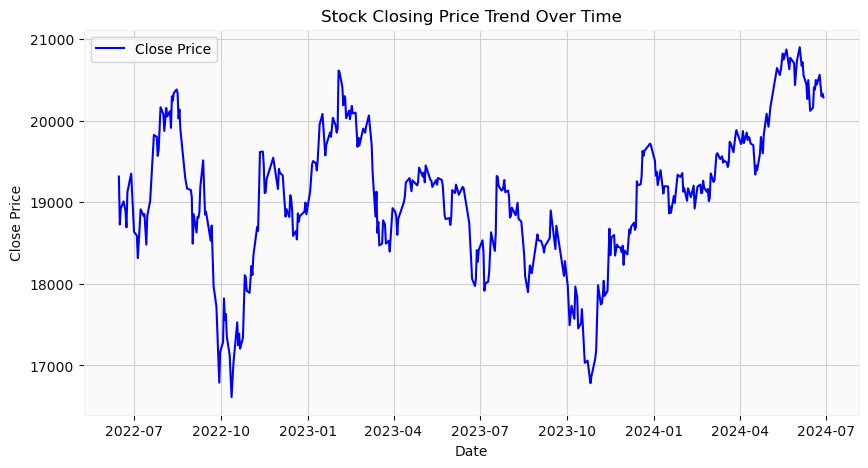

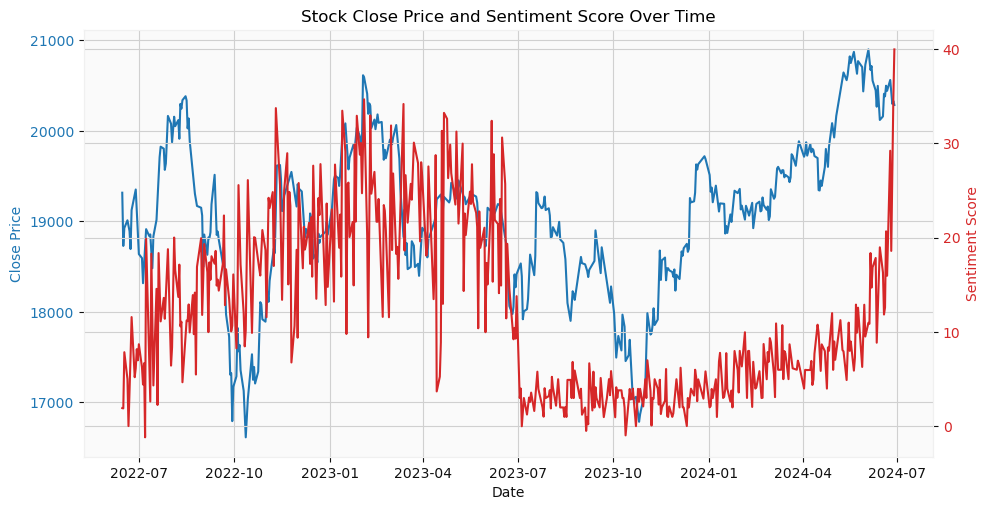

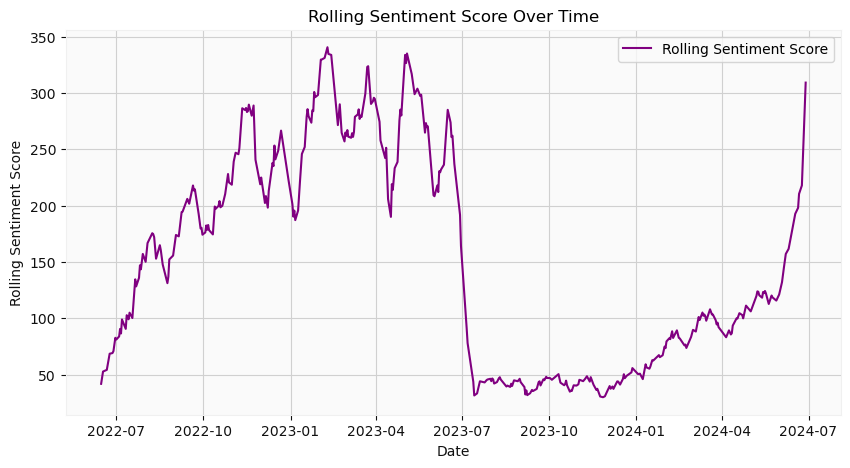

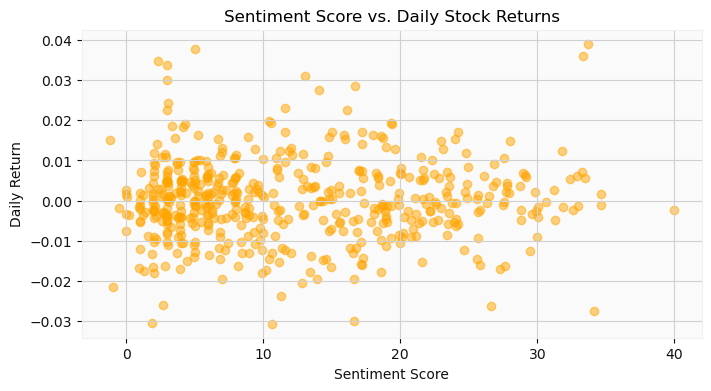

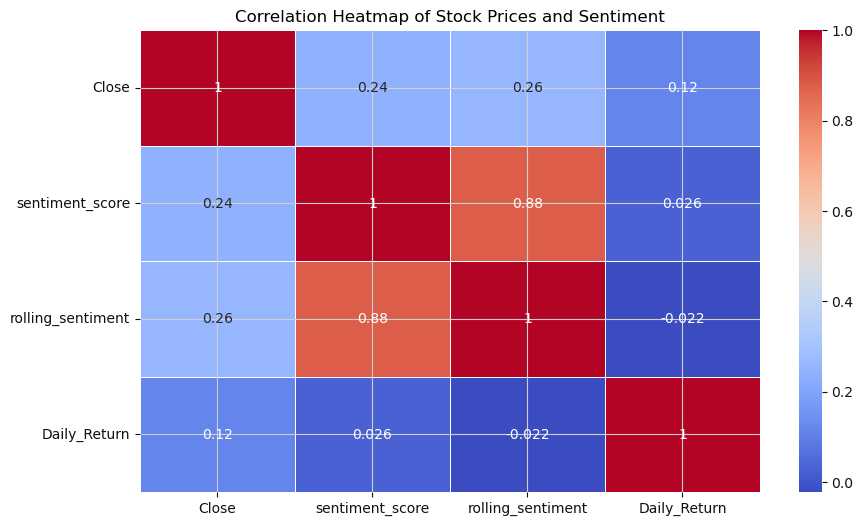

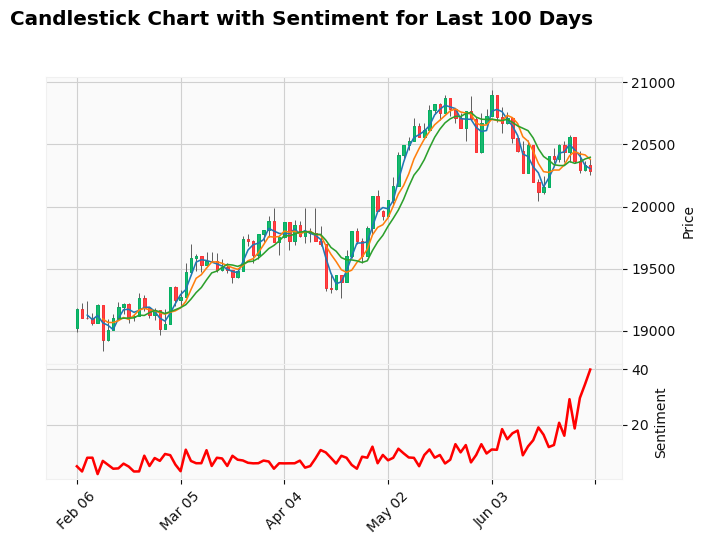

In [88]:


# create a new data frame from EDA
df_eda = data.copy()

# 1. Summary Statistics
summary_stats = df_eda[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'sentiment_score', 'rolling_sentiment']].describe()
print("Summary Statistics:")
print(summary_stats)

# 2. Stock Price Trend Over Time
plt.figure(figsize=(10,5))
plt.plot(df_eda.index, df_eda['Close'], color='blue', label='Close Price')
plt.title('Stock Closing Price Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()

# 3. Relationship Between Sentiment Score and Stock Prices
fig, ax1 = plt.subplots(figsize=(10,5))

color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('Close Price', color=color)
ax1.plot(df_eda.index, df_eda['Close'], color=color, label='Close Price')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes sharing the same x-axis
color = 'tab:red'
ax2.set_ylabel('Sentiment Score', color=color)
ax2.plot(df_eda.index, df_eda['sentiment_score'], color=color, label='Sentiment Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  
plt.title('Stock Close Price and Sentiment Score Over Time')
plt.grid(True)
plt.show()

# 4. Rolling Sentiment Analysis
plt.figure(figsize=(10,5))
plt.plot(df_eda.index, df_eda['rolling_sentiment'], color='purple', label='Rolling Sentiment Score')
plt.title('Rolling Sentiment Score Over Time')
plt.xlabel('Date')
plt.ylabel('Rolling Sentiment Score')
plt.legend()
plt.grid(True)
plt.show()

# 5. Scatter Plot: Sentiment Score vs. Daily Stock Returns
# Calculate daily returns
df_eda['Daily_Return'] = df_eda['Close'].pct_change()

# Scatter plot
plt.figure(figsize=(8,4))
plt.scatter(df_eda['sentiment_score'], df_eda['Daily_Return'], alpha=0.5, color='orange')
plt.title('Sentiment Score vs. Daily Stock Returns')
plt.xlabel('Sentiment Score')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()

# 6. Correlation Heatmap
plt.figure(figsize=(10,6))
correlation_matrix = df_eda[['Close', 'sentiment_score', 'rolling_sentiment', 'Daily_Return']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap of Stock Prices and Sentiment')
plt.show()

# 7. Candlestick Chart with Sentiment
# Adding sentiment score to the candlestick chart
mpf.plot(df_eda[-100:], type='candle',  title='Candlestick Chart with Sentiment for Last 100 Days', 
         style='yahoo', mav=(3,6,9), addplot=mpf.make_addplot(df_eda['sentiment_score'][-100:], panel=1, color='red', ylabel='Sentiment'))


In [89]:
# Checking if 'Date' is in the index
if 'date' in data.index.names:
  print("The index is 'Date'")
else:
  print("The index is not 'Date'")

The index is 'Date'


### Creating target variable y

In [90]:
window = 15
data['Target'] = data['Close'].shift(-window)

### Labelling of data

In [91]:
def create_dataset_with_sentiments(data, window=15):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[['Close', 'sentiment_score']].iloc[i:i+window].values)
        y.append(data['Target'][i])
    return np.array(X), np.array(y)

### Data splitting and scaling

In [92]:
# Data Splitting: Training, Validation and test set
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.15)

train_data = data[:train_size]
val_data = data[train_size :train_size+val_size]
test_data = data[train_size+val_size:]

def rolling_min_max_scaling(train_data, val_data, test_data, window=15):
    scaler = MinMaxScaler()
    scaled_train_data = train_data.copy()
    scaled_val_data = val_data.copy()
    scaled_test_data = test_data.copy()

    # Scale training data
    for i in range(len(train_data)):
        start_idx = max(0, i - window + 1)
        end_idx = i + 1
        window_data = train_data[start_idx:end_idx]
        scaled_window = scaler.fit_transform(window_data)
        scaled_train_data.iloc[i] = scaled_window[-1]

    # Scale validation data
    for i in range(len(val_data)):
        start_idx = max(0, len(train_data) - window + 1)
        end_idx = len(train_data) + i + 1
        window_data = np.vstack((train_data[start_idx:], val_data.iloc[:i+1]))
        scaled_window = scaler.fit_transform(window_data)
        scaled_val_data.iloc[i] = scaled_window[-1]

    # Scale test data
    for i in range(len(test_data)):
        start_idx = max(0, len(train_data) + len(val_data) - window + 1)
        end_idx = len(train_data) + len(val_data) + i + 1
        window_data = np.vstack((train_data[-window:], val_data, test_data.iloc[:i+1]))
        scaled_window = scaler.fit_transform(window_data)
        scaled_test_data.iloc[i] = scaled_window[-1]

    return scaled_train_data, scaled_val_data, scaled_test_data, scaler


# Apply the scaling to selected columns by name
selected_columns = ['Close', 'sentiment_score','Target']
scaled_train_data, scaled_val_data, scaled_test_data, scaler = rolling_min_max_scaling(
    train_data[selected_columns],
    val_data[selected_columns],
    test_data[selected_columns]
)

In [93]:
scaled_train_data.head(20)

,Close,sentiment_score,Target
date,,,
2022-06-15,0.000000,0.000000,0.000000
2022-06-16,0.000000,0.000000,1.000000
2022-06-17,0.337129,1.000000,1.000000
2022-06-20,0.481395,0.522318,0.761381
2022-06-21,0.376550,0.000000,0.817896
2022-06-22,0.278163,0.357709,0.367034
2022-06-23,0.000000,0.946833,0.000000
2022-06-24,0.691331,1.000000,0.816796
2022-06-27,1.000000,0.448341,1.000000


### Model build

In [94]:
# Setting seeds so model produce same results
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [95]:
# Creating datasets
window_size = 15
X_train, y_train = create_dataset_with_sentiments(scaled_train_data[['Close', 'sentiment_score', 'Target']], window=window_size)
X_val, y_val = create_dataset_with_sentiments(scaled_val_data[['Close', 'sentiment_score', 'Target']], window=window_size)
X_test, y_test = create_dataset_with_sentiments(scaled_test_data[['Close', 'sentiment_score', 'Target']], window=window_size)

# Reshaping data for LSTM and CNN
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val_lstm = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

X_train_cnn = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_val_cnn = X_val.reshape((X_val.shape[0], X_val.shape[1], X_val.shape[2]))
X_test_cnn = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Displaying the shapes
print("\nTraining Data Shape:")
print("X_train:", X_train.shape)
print("y_train:", y_train.shape)

# Displaying the shapes
print("\nTesting Data Shape:")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)


Training Data Shape:
X_train: (345, 15, 2)
y_train: (345,)

Testing Data Shape:
X_test: (63, 15, 2)
y_test: (63,)


### CNN model

In [96]:
# CNN Model
cnn_model = Sequential([
    Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(window_size, X_train_cnn.shape[2])),
    Flatten(),
    Dense(50, activation='relu'),
    Dense(1)
])
cnn_model.compile(optimizer='adam', loss='mean_squared_error')
history_cnn = cnn_model.fit(X_train_cnn, y_train, validation_data=(X_val_cnn, y_val),epochs=10, batch_size=16, verbose=0)

# Predict with CNN
cnn_predictions_scaled = cnn_model.predict(X_test_cnn)

close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0] # Extract the scaler for the 'Close' column

# Reverse Scaling for CNN
cnn_predictions = close_scaler.inverse_transform(cnn_predictions_scaled)

cnn_predictions = cnn_predictions[:, 0]

C:\Users\bhart\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


In [97]:
cnn_predictions

array([20371.424, 20579.031, 20353.297, 20347.139, 20636.324, 20434.84 ,
       20445.846, 20414.078, 20535.924, 20380.285, 20355.408, 20384.59 ,
       20125.762, 20088.117, 20039.406, 20055.504, 20267.014, 20377.871,
       20068.383, 20021.582, 20489.957, 20577.707, 20399.85 , 20401.266,
       20711.709, 20904.434, 20685.8  , 20669.045, 20715.502, 20746.68 ,
       20470.348, 20547.387, 20538.36 , 20759.84 , 20450.3  , 20614.572,
       20631.643, 20497.03 , 20548.479, 20510.469, 20455.846, 20423.344,
       20485.639, 20510.543, 20540.879, 20395.033, 20598.197, 20724.46 ,
       20271.879, 20315.785, 20154.938, 20398.498, 20164.748, 19994.953,
       20133.088, 20103.438, 20174.842, 20228.227, 20490.75 , 20306.098,
       20107.71 , 20178.908, 20421.55 ], dtype=float32)

### LSTM Model

In [98]:
# LSTM Model
lstm_model = Sequential([
    LSTM(50, activation='relu', input_shape=(window_size, 2)),
    Dense(50, activation='relu'),
    Dense(1)
    ])
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
history_lstm = lstm_model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val),epochs=15, batch_size=16, verbose=0)

# Predict with LSTM
lstm_predictions_scaled = lstm_model.predict(X_test_lstm)

close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0] # Extract the scaler for the 'Close' column

# Reverse Scaling for CNN
lstm_predictions = close_scaler.inverse_transform(lstm_predictions_scaled)

lstm_predictions = lstm_predictions[:, 0]

C:\Users\bhart\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


### ANN Model

In [100]:
# ANN Model
ann_model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1] * X_train.shape[2],)),
    Dense(50, activation='relu'),
    Dense(1)
])
ann_model.compile(optimizer='adam', loss='mean_squared_error')
# Reshape X_val to match the input shape of the ANN
history_ann = ann_model.fit(X_train.reshape(X_train.shape[0], -1), y_train,
              validation_data=(X_val.reshape(X_val.shape[0], -1), y_val),
              epochs=6, batch_size=16, verbose=0)

# Predict with ANN
ann_predictions_scaled = ann_model.predict(X_test.reshape(X_test.shape[0], -1))

close_scaler = MinMaxScaler()
close_scaler.min_, close_scaler.scale_ = scaler.min_[0], scaler.scale_[0] # Extract the scaler for the 'Close' column
# Reverse Scaling for ANN
ann_predictions = close_scaler.inverse_transform(ann_predictions_scaled)

ann_predictions = ann_predictions[:, 0]

C:\Users\bhart\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


### Plot training & validation loss values

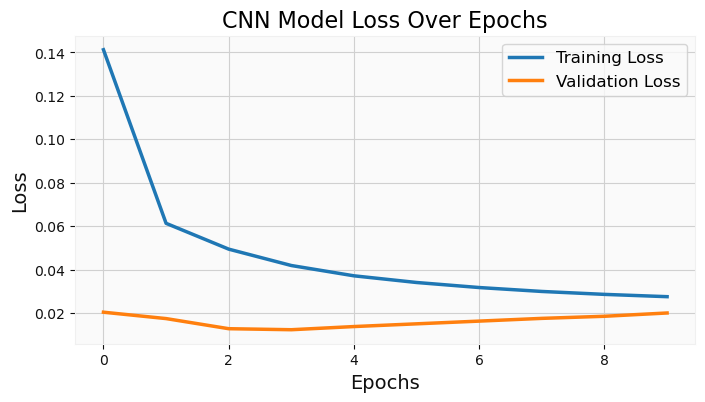

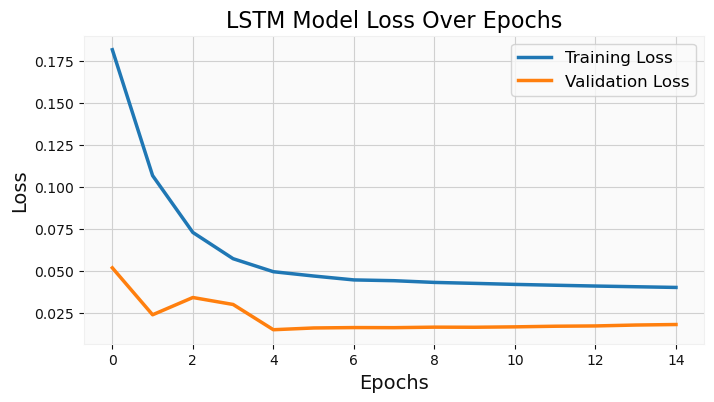

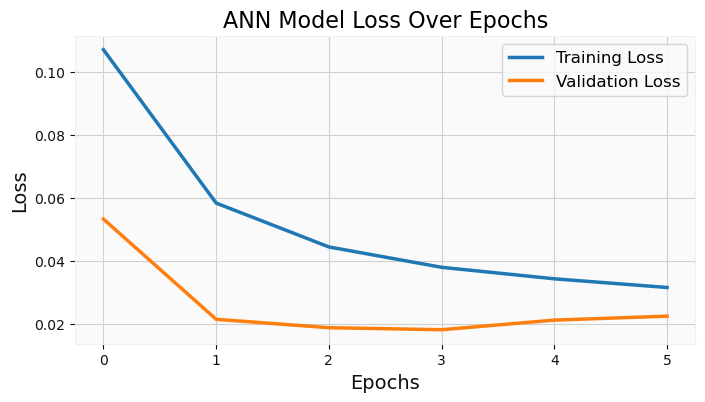

In [102]:
# CNN Plot
plt.figure(figsize=(8, 4))
plt.plot(history_cnn.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_cnn.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('CNN Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

#LSTM Plot
plt.figure(figsize=(8, 4))
plt.plot(history_lstm.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_lstm.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('LSTM Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

# ANN Plot
plt.figure(figsize=(8, 4))
plt.plot(history_ann.history['loss'], label='Training Loss', linewidth=2.5)
plt.plot(history_ann.history['val_loss'], label='Validation Loss', linewidth=2.5)
plt.title('ANN Model Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(loc='upper right', fontsize=12)
plt.grid(True)
plt.show()

### Evaluation of the models 

CNN - MAE: 354.17, MSE: 185330.28, RMSE: 430.50
LSTM - MAE: 389.88, MSE: 221284.99, RMSE: 470.41
ANN - MAE: 381.24, MSE: 227126.81, RMSE: 476.58


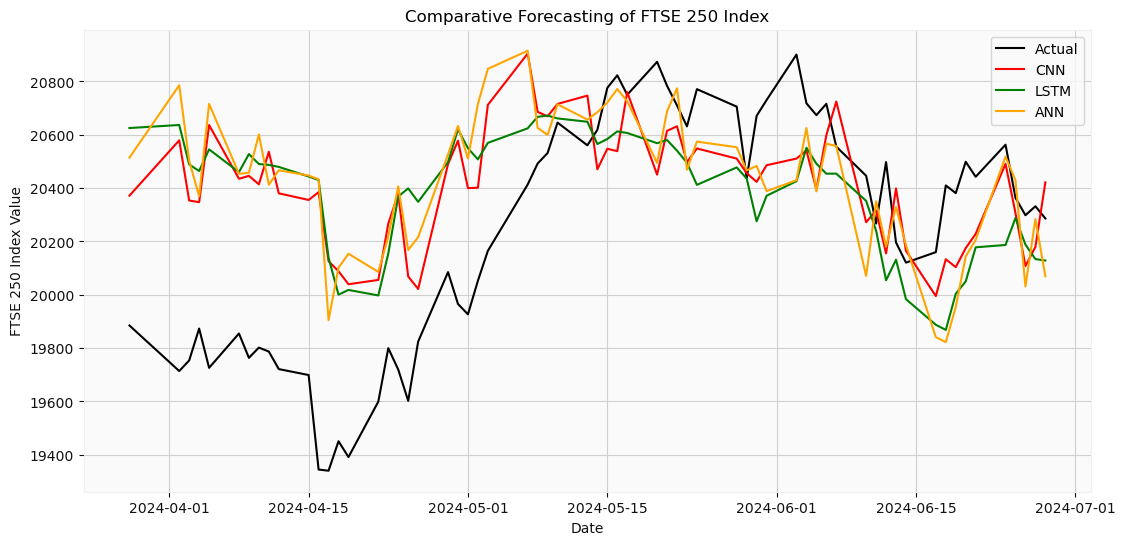

In [108]:
# Evaluation
def evaluate_model(true_values, predictions, model_name):
    # Ensuring predicted and true values have the same length for comparison
    min_length = min(len(true_values), len(predictions))
    true_values = true_values[:min_length]
    predictions = predictions[:min_length]

    mae = mean_absolute_error(true_values, predictions) # Now compares arrays of the same length
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

# Evaluate models on test data, ensuring consistent lengths
evaluate_model(test_data['Target'], cnn_predictions, "CNN")
evaluate_model(test_data['Target'], lstm_predictions, "LSTM")
evaluate_model(test_data['Target'], ann_predictions, "ANN")

# Comparative Analysis
plt.figure(figsize=(13, 6))

# Adjust the slicing of arima_forecast to match the length of test_data['Close'][window_size:]
plt.plot(test_data.index[window_size:], test_data['Close'][window_size:], label='Actual', color='black')
plt.plot(test_data.index[window_size:], cnn_predictions, label='CNN', color='red')
plt.plot(test_data.index[window_size:], lstm_predictions, label='LSTM', color='green')
plt.plot(test_data.index[window_size:], ann_predictions, label='ANN', color='orange')

plt.title('Comparative Forecasting of FTSE 250 Index')
plt.xlabel('Date')
plt.ylabel('FTSE 250 Index Value')
plt.legend()
plt.show()

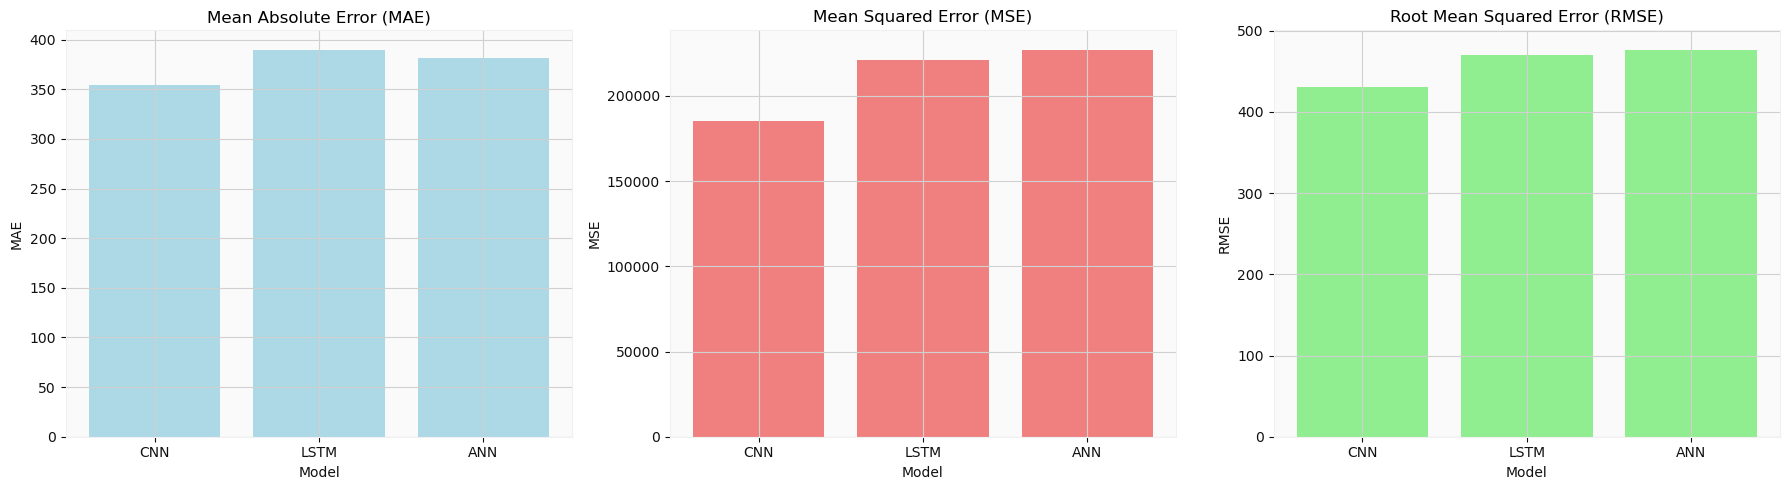

In [105]:
def evaluate_model(true_values, predictions):
    min_length = min(len(true_values), len(predictions))
    true_values = true_values[:min_length]
    predictions = predictions[:min_length]
    
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    
    return mae, mse, rmse

# Assuming you have the true values and predictions for each model
true_values = test_data['Close'][window_size:]
models_predictions = {
    'CNN': cnn_predictions,
    'LSTM': lstm_predictions,
    'ANN': ann_predictions
}

# Compute metrics for each model
metrics = {model: evaluate_model(true_values, preds) for model, preds in models_predictions.items()}

# Prepare data for plotting
models = list(metrics.keys())
mae_values = [metrics[model][0] for model in models]
mse_values = [metrics[model][1] for model in models]
rmse_values = [metrics[model][2] for model in models]

# Plot MAE, MSE, and RMSE
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# MAE
axs[0].bar(models, mae_values, color='lightblue')
axs[0].set_title('Mean Absolute Error (MAE)')
axs[0].set_xlabel('Model')
axs[0].set_ylabel('MAE')

# MSE
axs[1].bar(models, mse_values, color='lightcoral')
axs[1].set_title('Mean Squared Error (MSE)')
axs[1].set_xlabel('Model')
axs[1].set_ylabel('MSE')

# RMSE
axs[2].bar(models, rmse_values, color='lightgreen')
axs[2].set_title('Root Mean Squared Error (RMSE)')
axs[2].set_xlabel('Model')
axs[2].set_ylabel('RMSE')

plt.tight_layout()
plt.show()


### Predicting 15th and 30th day from today using predicted data

CNN - MAE: 240.60, MSE: 80681.93, RMSE: 284.05
LSTM - MAE: 208.89, MSE: 70315.13, RMSE: 265.17
ANN - MAE: 221.65, MSE: 69302.58, RMSE: 263.25

Comparison of 15th and 30th Day Predictions with Actual Values:
15th Day (2024-06-17 00:00:00): Actual: 20159.70, CNN: 20355.41, LSTM: 20443.42, ANN: 20447.05
30th Day (2024-06-28 00:00:00): Actual: 20286.00, CNN: 20021.58, LSTM: 20348.49, ANN: 20215.96


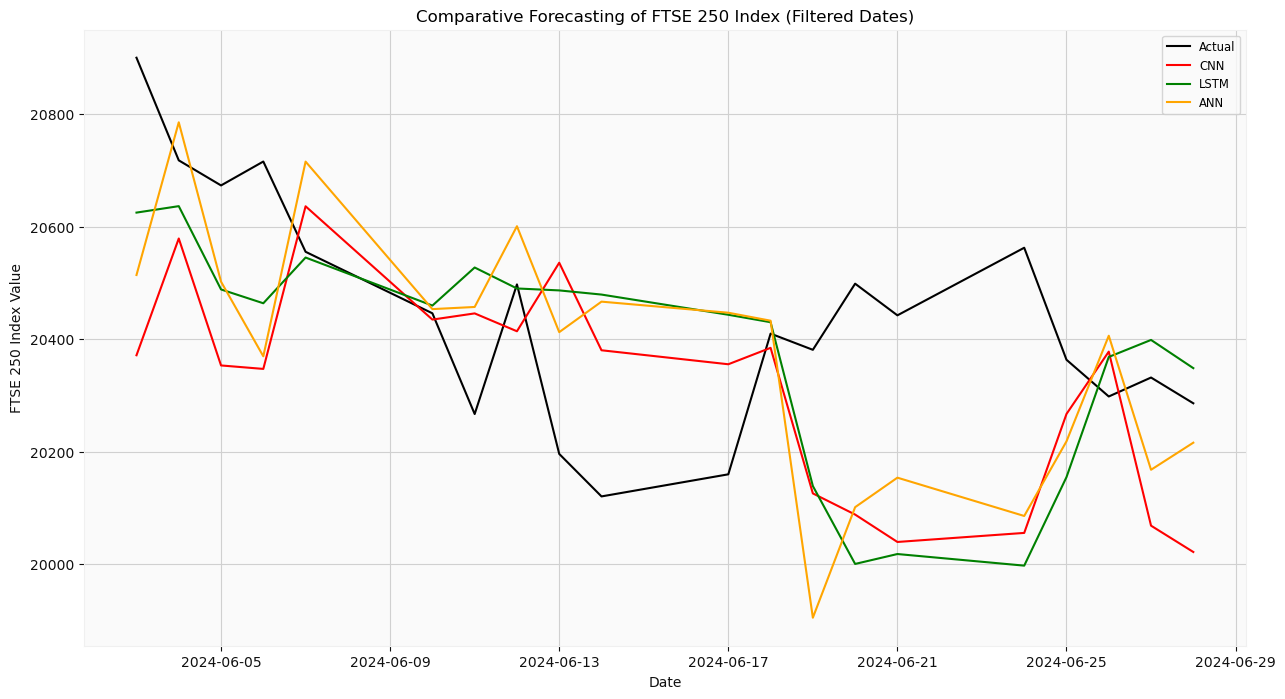

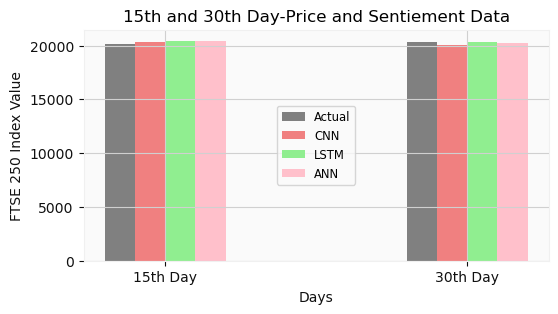

In [107]:
def evaluate_model(true_values, predictions, model_name):
    min_length = min(len(true_values), len(predictions))
    true_values = true_values[:min_length]
    predictions = predictions[:min_length]

    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    print(f"{model_name} - MAE: {mae:.2f}, MSE: {mse:.2f}, RMSE: {rmse:.2f}")

# Specify the date range for plotting
start_date = '2024-06-01'
end_date = '2024-07-03'

# Filter the test data for the specified date range
filtered_test_data = test_data.loc[(test_data.index >= start_date) & (test_data.index <= end_date)]

# Get the corresponding index positions from the filtered test data
filtered_indices = filtered_test_data.index.get_indexer(filtered_test_data.index)

# Filter the predictions using these index positions
filtered_cnn_predictions = np.array(cnn_predictions)[filtered_indices]
filtered_lstm_predictions = np.array(lstm_predictions)[filtered_indices]
filtered_ann_predictions = np.array(ann_predictions)[filtered_indices]

# Evaluate models on the filtered test data
evaluate_model(filtered_test_data['Close'], filtered_cnn_predictions, "CNN")
evaluate_model(filtered_test_data['Close'], filtered_lstm_predictions, "LSTM")
evaluate_model(filtered_test_data['Close'], filtered_ann_predictions, "ANN")

# Extracting the 15th and 30th day's actual and predicted values
day_15 = 10  # Index for 15th day (data containes only business days, so 11th corresponds to 15th day)
day_30 = 19  # Index for 30th day (data containes only business days or where news is available, so 19th bday corresponds to 30th day)

# Get actual values and predictions for the 15th and 30th day
actual_15 = filtered_test_data['Close'].iloc[day_15]
cnn_15 = filtered_cnn_predictions[day_15]
lstm_15 = filtered_lstm_predictions[day_15]
ann_15 = filtered_ann_predictions[day_15]

actual_30 = filtered_test_data['Close'].iloc[day_30]
cnn_30 = filtered_cnn_predictions[day_30]
lstm_30 = filtered_lstm_predictions[day_30]
ann_30 = filtered_ann_predictions[day_30]

# Print comparison for the 15th and 30th days
print("\nComparison of 15th and 30th Day Predictions with Actual Values:")
print(f"15th Day ({filtered_test_data.index[day_15]}): Actual: {actual_15:.2f}, CNN: {cnn_15:.2f}, LSTM: {lstm_15:.2f}, ANN: {ann_15:.2f}")
print(f"30th Day ({filtered_test_data.index[day_30]}): Actual: {actual_30:.2f}, CNN: {cnn_30:.2f}, LSTM: {lstm_30:.2f}, ANN: {ann_30:.2f}")

# Plotting the actual and predicted values for the entire month
plt.figure(figsize=(15, 8))

# Plot the actual values
plt.plot(filtered_test_data.index, filtered_test_data['Close'], label='Actual', color='black')

# Plot the CNN, LSTM, and ANN predictions
plt.plot(filtered_test_data.index, filtered_cnn_predictions, label='CNN', color='red')
plt.plot(filtered_test_data.index, filtered_lstm_predictions, label='LSTM', color='green')
plt.plot(filtered_test_data.index, filtered_ann_predictions, label='ANN', color='orange')

plt.title('Comparative Forecasting of FTSE 250 Index (Filtered Dates)')
plt.xlabel('Date')
plt.ylabel('FTSE 250 Index Value')

# Adjust legend location to the top right and make it smaller
plt.legend(loc='upper right', fontsize='small')

# Display the plot
plt.show()

# Pictorial representation for the 15th and 30th day comparison
fig, ax = plt.subplots(figsize=(6, 3))

# Bar labels and values for the 15th and 30th days
labels = ['15th Day', '30th Day']
actual_values = [actual_15, actual_30]
cnn_values = [cnn_15, cnn_30]
lstm_values = [lstm_15, lstm_30]
ann_values = [ann_15, ann_30]

# X positions for the bars
x = np.arange(len(labels))

# Bar width
bar_width = 0.1

# Plot bars for actual and model predictions with light colors
ax.bar(x - bar_width, actual_values, bar_width, label='Actual', color='grey')
ax.bar(x, cnn_values, bar_width, label='CNN', color='lightcoral')
ax.bar(x + bar_width, lstm_values, bar_width, label='LSTM', color='lightgreen')
ax.bar(x + 2 * bar_width, ann_values, bar_width, label='ANN', color='pink')

# Add some text for labels, title, and custom x-axis tick labels, etc.
ax.set_xlabel('Days')
ax.set_ylabel('FTSE 250 Index Value')
ax.set_title('15th and 30th Day-Price and Sentiement Data')
ax.set_xticks(x + bar_width / 2)
ax.set_xticklabels(labels)

# Adjust legend location to the top right and make it smaller
ax.legend(loc='center', fontsize='small')

# Display the bar plot
plt.show()